<a href="https://colab.research.google.com/github/FB1-MTP/MR-Simulator/blob/main/MTP_FB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **MR simulator to create tailored datasets of MR Images for AI Algorithm Development**

Load libraries and Declare Constants

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
Gamma= 4.28E7 #Hz/Tesla
N_W= 6.69E28
plank_c= 6.626E-34
boltz_c= 1.38E-23
temp_sample= 293.0
spin_quant_no= 0.5
B0=1
csf_params=[1, 4.5, 2.2]
gm_params= [0.8, 0.95, 0.1]
wm_params= [0.65, 0.1, 10]
newparams= [0, 0.05, 1]
##user 



#formulae used: Acquisition time= 1/gamma*gradient 
#refer page 116 (Picture to proton)
#################################################USER DEFINED PARAMETERS#################################

fov= 0.011
Vs = fov**3
NOP=11
Acq_bdw= 10E3
flip_angle = 90
R = 0.5
B1xy = 1 #Tesla

##user defined parameters end

delta_y= fov/NOP
delta_x= fov/NOP
#print(delta_x)

tou= 1E-3
#GMax_Min=  ## fixed tou
GMax_x_y = NOP/ (Gamma*delta_x*tou*2*2)
#######################################################3 CHHAANGEE ********************###############
delta_t_fe= 1/Acq_bdw
delta_z= fov/NOP
G_z= 1/ (Gamma*delta_z*delta_t_fe*2)


g1s = 0 # start time gradient1
g1e = tou # end time gradient1
g2s = tou # start time gradient 2
g2e = tou*2
g3s = tou*2
g3e = tou*2+delta_t_fe*NOP
g1max = GMax_x_y
g2max = GMax_x_y
g3 = G_z
print(G_z)
Delta_T = delta_t_fe

0.11682242990654206


Declare Functions

In [ ]:
def create_spherical_region(parameters, center , radius, phantom): 
  '''
    Changes the "parameters" passed as [Rho, T1, T2] values of all voxels 
    within R "radius" sphere from the "center" passed as [Cx,Cy,Cz] in the phantom
  '''
  if phantom.shape[0]==phantom.shape[1]==phantom.shape[2]:
    dimensions =  phantom.shape[0]
  else:
    dimensions = 1

  [Cx, Cy, Cz] = center

  minX = max(0, Cx-radius)
  maxX = min(Cx+radius, dimensions-1)
  minY = max(0, Cy-radius)
  maxY = min(Cy+radius, dimensions-1)
  minZ = max(0, Cz-radius)
  maxZ = min(Cz+radius, dimensions-1)
  
  for i in range(minX,maxX):
    for j in range(minY, maxY):
      for k in range(minZ, maxZ):
        if(radius**2 >= (Cx-i)**2+(Cy-j)**2+(Cz-k)**2):
          phantom[i][j][k] = np.array(parameters)

def initialize_phantom(dimensions, default_parameters):
  '''
    Creates a N*N*N 3D phantom with N as "dimensions", implemented as numpy ndarray
    
    "default_parameters" a list of [Rho, T1, T2] is used to initialize each voxel of this phantom
  '''
  return np.full((dimensions,dimensions,dimensions,3), default_parameters)


def create_cubical_region(parameters, center , radius, phantom): 
  '''
    Changes the "parameters" passed as [Rho, T1, T2] values of all voxels 
    within R "radius" sphere from the "center" passed as [Cx,Cy,Cz] in the phantom
  '''
  if phantom.shape[0]==phantom.shape[1]==phantom.shape[2]:
    dimensions =  phantom.shape[0]
  else:
    dimensions = 1

  [Cx, Cy, Cz] = center

  minX = max(0, Cx-radius)
  maxX = min(Cx+radius, dimensions-1)
  minY = max(0, Cy-radius)
  maxY = min(Cy+radius, dimensions-1)
  minZ = max(0, Cz-radius)
  maxZ = min(Cz+radius, dimensions-1)
  
  for i in range(minX,maxX):
    for j in range(minY, maxY):
      for k in range(minZ, maxZ):
        phantom[i][j][k] = np.array(parameters)


def InitializeMagnetizationMatrix(dimentions, phantom, B0):
  res= np.full((dimentions,dimentions,dimentions, 3), [0., 0., 0.])
  for i in range(dimentions):
    for j in range(dimentions):
      for k in range(dimentions):
        res[i][j][k][2]= 0.00325*(phantom[i][j][k][0])# (3.25E-3)*(phantom[i][j][k][0])
  return res

def pulse(flip_angle, MagMat, axis): #if axis=x magnetization flips into y and vice versa
  dimentions= np.shape(MagMat)[0]
  if(axis=='x'):
    for i in range(dimentions):
      for j in range(dimentions):
        for k in range(dimentions):
          MagMat[i][j][k][0]= math.sin(math.radians(flip_angle))*MagMat[i][j][k][2]
          MagMat[i][j][k][2]= math.cos(math.radians(flip_angle))*MagMat[i][j][k][2]
  elif(axis=='y'):
    for i in range(dimentions):
      for j in range(dimentions):
        for k in range(dimentions):
          MagMat[i][j][k][1]= math.sin(math.radians(flip_angle))*MagMat[i][j][k][2]
          MagMat[i][j][k][2]= math.cos(math.radians(flip_angle))*MagMat[i][j][k][2]
  else:
    print("Invalid axis of rotation for pulse")

def SumMagnetizationOverSample(MagMat):
  return np.apply_over_axes(np.sum, MagMat, [0, 1, 2])




def CalculateRotationMatrixZ(B, Gamma,  Delta_T):
  theta = Gamma*B*Delta_T
  return np.array([[math.cos(theta), -math.sin(theta), 0],[math.sin(theta), math.cos(theta), 0], [0,0,1]])


def rotateAcrossAxisZRelax(B0, M, B, Gamma, Delta_T, params, T):
  #params: Rho, T1, T2
  T1, T2 = params[1], params[2]
  rho= params[0]
  count= int(T/Delta_T)
  evolution_of_m= np.zeros((count, 3))
  rot= CalculateRotationMatrixZ(B, Gamma, Delta_T)
  ## Magnetization from proton density
  ## Check reference:  https://radiopaedia.org/articles/dependence-of-magnetisation-proton-density-field-strength-and-temperature
  ## M0 = (γ2 h2 B0 Ntotal) / (16 π2 kT) #### M0 = 1.177*B0*Ntotal for Hydrogen
  M0= 3.25E-3*rho*B0
  ## dMz/dt= M0-Mz/T1 
  i=0
  while(count>0):
    M=np.matmul(rot, M)
    Delta_M= np.array([-M[0]/T2*Delta_T, -M[1]/T2*Delta_T, (M0-M[2])/T1*Delta_T])
    M= np.add(M, Delta_M)
    evolution_of_m[i]=M
    count=count-1
    i=i+1
  return evolution_of_m


def rotateAcrossAxisZRF(B0, M, B, Gamma, Delta_T, params, T):
  
  #params: Rho, T1, T2
  #print("O", M)
  T1, T2 = params[1], params[2]
  rho= params[0]
  count= int(T/Delta_T)
  rot= CalculateRotationMatrixZ(B, Gamma, Delta_T)
  ## Magnetization from proton density
  ## Check reference:  https://radiopaedia.org/articles/dependence-of-magnetisation-proton-density-field-strength-and-temperature
  ## M0 = (γ2 h2 B0 Ntotal) / (16 π2 kT) #### M0 = 1.177*B0*Ntotal for Hydrogen
  M0= 3.25E-3*rho*B0
  ## dMz/dt= M0-Mz/T1 
  i=0
  while(count>0):
    M=np.matmul(rot, M)
    Delta_M= np.array([-M[0]/T2*Delta_T, -M[1]/T2*Delta_T, (M0-M[2])/T1*Delta_T])
    M= np.add(M, Delta_M)
    count=count-1
    i=i+1
  #print(M)
  return M

def rotateAcrossAxisZRelaxFinal(B0, M, B, Gamma, Delta_T, params, T):
  
  #params: Rho, T1, T2
  #print("O", M)
  T1, T2 = params[1], params[2]
  rho= params[0]
  rot= CalculateRotationMatrixZ(B, Gamma, T)
  ## Magnetization from proton density
  ## Check reference:  https://radiopaedia.org/articles/dependence-of-magnetisation-proton-density-field-strength-and-temperature
  ## M0 = (γ2 h2 B0 Ntotal) / (16 π2 kT) #### M0 = 1.177*B0*Ntotal for Hydrogen
  M0= 3.25E-3*rho*B0
  ## dMz/dt= M0-Mz/T1 

  M=np.matmul(rot, M)
  Delta_M= np.array([-M[0]/T2*T, -M[1]/T2*T, (M0-M[2])/T1*T])
  M= np.add(M, Delta_M)
  #print(M)
  return M

def apply_gradient(phantom, Gamma, axis, gradient, Delta_T, T, MagMat, B0, delta_x, delta_y, delta_z):
  if(T==0.0):
    return
  dim= len(MagMat)
  
  #print(min_b)#####
  if(T==0):
    return
  for i in range(dim):
    if(axis=='x'):
      max_b= gradient*((dim-1)/2)*delta_x
      min_b= -gradient*((dim-1)/2)*delta_x
      B=min_b+i*gradient*delta_x
      #print(B)#####
    for j in range(dim):
      if(axis=='y'):
        max_b= gradient*((dim-1)/2)*delta_y
        min_b= -gradient*((dim-1)/2)*delta_y
        B=min_b+j*gradient*delta_y
      for k in range(dim):
        if(axis=='z'):
          max_b= gradient*((dim-1)/2)*delta_z
          min_b= -gradient*((dim-1)/2)*delta_z
          B=min_b+k*gradient*delta_z
        #print(B0, MagMat[i][j][k], B, Gamma, Delta_T, phantom[i][j][k], T)
        MagMat[i][j][k]=rotateAcrossAxisZRelaxFinal(B0, MagMat[i][j][k], B, Gamma, Delta_T, phantom[i][j][k], T)
        #print(MagMat[i][j][k])


def plott(slice):
# Creating arrow
  x = []
  y = []

  u=[]
  v=[]
  for i in range(len(slice)):
    for j in range(len(slice[0])):
      u.append(slice[i][j][0])
      v.append(slice[i][j][1])
      x.append(i)
      y.append(j)

  #X, Y = np.meshgrid(x, y)

 
# creating plot
  fig, ax = plt.subplots(figsize =(11, 11))
  ax.quiver(x, y, u, v)
 
  ax.xaxis.set_ticks([])
  ax.yaxis.set_ticks([])
  #ax.axis([-0.3, 2.3, -0.3, 2.3])
  ax.set_aspect('equal')
  plt.savefig("magvec")
# show plot
  plt.show()
def sequence1(phantom, g1s, g1e, g1, g2s, g2e, g2, g3s, g3e, g3, B0, KSpace, i, j, MagMat, Delta_T, delta_x, delta_y, delta_z):
  dimentions= len(phantom)
  #plott(MagMat[1])
  apply_gradient(phantom, Gamma, 'z', 0, Delta_T, g1s-0, MagMat, B0, delta_x, delta_y, delta_z) # relaxation before gradient1
  apply_gradient(phantom, Gamma, 'x', g1, Delta_T, g1e-g1s, MagMat, B0, delta_x, delta_y, delta_z) # relaxation during gradient1
  #print(g1)

  if(i==-1):
    plott(MagMat[int(dimentions/2)])
    ind=int(dimentions/2)
    img=np.zeros((dimentions, dimentions, 3))
    for i in range(len(phantom)):
      for j in range(len(phantom)):
        for k in range(len(phantom)):
          if(j==ind):
            img[i][k]=MagMat[i][j][k]
    plott(img)
    img=np.zeros((dimentions, dimentions, 3))
    for i in range(len(phantom)):
      for j in range(len(phantom)):
        for k in range(len(phantom)):
          if(k==ind):
            img[i][j]=MagMat[i][j][k]
    plott(img)
    return
  
  ####
  apply_gradient(phantom, Gamma, 'z', 0, Delta_T, g2s-g1e, MagMat, B0, delta_x, delta_y, delta_z) #relaxation bw gradient1 and gradient2
  apply_gradient(phantom, Gamma, 'y', g2, Delta_T, g2e-g2s, MagMat, B0, delta_x, delta_y, delta_z) # relaxation during gradient2
  #plott(MagMat[1])
  apply_gradient(phantom, Gamma, 'z', 0, Delta_T, g3s-g2e, MagMat, B0, delta_x, delta_y, delta_z) #relaxation bw gradient2 and gradient3
  apply_gradient(phantom, Gamma, 'z', -g3/2, Delta_T, (g3e-g3s), MagMat, B0, delta_x, delta_y, delta_z) #reverse gradient to move left in k space before sampling
  timestep_g3= (g3e-g3s)/(dimentions-1.0)
  for k in range(dimentions): 
    #####
    #if(i==1 and j==1):
      #plott(MagMat[0])
      #plott(MagMat[1])
      #print(MagMat[1])
      #plott(MagMat[2])
      #print(g1, g2, g3)
      #return
    ####
    KSpace[i][j][k]= SumMagnetizationOverSample(MagMat)
    apply_gradient(phantom, Gamma, 'z', g3, Delta_T, timestep_g3, MagMat, B0, delta_x, delta_y, delta_z)

    
    #print("completed 1 0f 1000")
  #plott(MagMat[1])




def seq(phantom, flip_angle, g1s, g1e, g1max, g2s, g2e, g2max, g3s, g3e, g3, B0, Delta_T, KSpace, delta_x, delta_y, delta_z):
  dimentions = len(phantom)
  #print(MagMat)
  x_gr_step= (2.0*g1max)/(dimentions-1.0)
  y_gr_step= (2.0*g2max)/(dimentions-1.0)
  for i in range(dimentions):
    for j in range(dimentions):
      MagMat= InitializeMagnetizationMatrix(dimentions, phantom, B0)
      pulse(flip_angle, MagMat, "x")
      #print(MagMat[1][1][1])
      sequence1(phantom, g1s, g1e, g1max-i*x_gr_step, g2s, g2e, g2max-j*y_gr_step, g3s, g3e, g3, B0, KSpace, i, j, MagMat, Delta_T, delta_x, delta_y, delta_z)
      if(i==-1):
        return
      ##
      #if(i==1 and j==1):
      #  return
      #print("completed 1 of 100")
  #return KSpace



In [ ]:
def calculateEMFgrid (M_grid, KB1xy=1, Omega = Gamma*B0, Vs=Vs):
  '''
    M_grid = Magnetization Mx, My, Mz of each voxel in M_grid
    Vs = Sample Volume = Volume of phantom
  '''
  K_space = np.zeros(shape = M_grid.shape[:-1])
  for i in range(len(M_grid)):
    for j in range(len(M_grid[0])):
      for k in range(len(M_grid[0][0])):
        Sigma_M = M_grid[i][j][k]
        Mxy_mag = math.sqrt(Sigma_M[0]**2+Sigma_M[1]**2)
        K_space[i][j][k] = KB1xy*Omega*Mxy_mag*Vs
  return K_space

def White_noise_matrix_adder(K_space, R=R, bandwith=Acq_bdw, k=boltz_c, Tc = temp_sample):
  mean = 0
  std = math.sqrt(4*k*Tc*bandwith*R)
  return np.random.normal(mean, std, size = np.prod(K_space.shape)).reshape(K_space.shape) + K_space

def InverseFourierTransform(K_space):
  ifft = np.fft.ifftn(K_space)
  ifft_shift = np.fft.fftshift(ifft)
  return ifft_shift

def InverseFourierTransform2D(K_space):
  ifft = []
  ifft_shift = []
  for i in range(len(K_space)):
    ifft.append(np.fft.ifft2(K_space[i]))
    ifft_shift.append(np.fft.fftshift(ifft[i]))
  return np.array(ifft_shift)


def imgFromKSpace(KSpace):
  """
    K-space should be path to a .npy sequence
  """
  print("-----LOADING K-SPACE-----")
  K_space = KSpace
  print("Min, Max and Avg values of elements in loaded K_space ")
  print(np.min(K_space)," ",np.max(K_space)," ",np.average(K_space),"\n")
  
  print("-----CALCULATING INDUCED VOLTAGE AS IN K-SPACE-----")
  K_spaceV = calculateEMFgrid(K_space)
  print("Min, Max and Avg values of elements in Induced Voltage K_space ")
  print(np.min(K_spaceV)," ",np.max(K_spaceV)," ",np.average(K_spaceV),"\n")
  
  print("-----ADDING NOISE TO INDUCED VOLTAGE K-SPACE-----")
  K_spaceN = White_noise_matrix_adder(K_spaceV)
  print("Min, Max and Avg values of elements in Induced Voltage K_space with Noise ")
  print(np.min(K_spaceN)," ",np.max(K_spaceN)," ",np.average(K_spaceN),"\n")

  print("Noise matrix min, max, std ", np.min(K_spaceN-K_spaceV)," ",np.max(K_spaceN-K_spaceV)," ",np.std(K_spaceN-K_spaceV),"\n")
  
  print("-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITHOUT NOISE-----")
  ifft = InverseFourierTransform(K_spaceV)
  print("-----PLOTTING IMAGES W/O NOISE-----")
  for i in range(len(K_space)):
    im = np.abs(ifft[i])
    plt.imshow(im, cmap='gray',vmin=0, vmax=np.abs(np.max(ifft)))
    plt.show()
  print("\n\n\n\n")

  print("-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITH NOISE-----")
  ifftN = InverseFourierTransform(K_spaceN)
  print("-----PLOTTING IMAGES WITH NOISE-----")
  for i in range(len(K_space)):
    imN = np.abs(ifftN[i])
    plt.imshow(imN, cmap='gray',vmin=0, vmax=np.abs(np.max(ifft)))
    plt.show()
  print("\n\n\n\n")

Main

In [ ]:
#Intialize Phantoms
phantomFull = initialize_phantom(NOP, csf_params)
phantomCenter = initialize_phantom(NOP, newparams)
phantomCenter[5][5][5] = [1, 4.5, 2.2]

In [ ]:
#Intialize Phantom
phantom = initialize_phantom(NOP, newparams)
#create_spherical_region(wm_params,[5,5,5],2, phantom)
phantom[5][5][5]= [1e-9, 4.5, 2.2]
#phantom[6][5][5]= wm_params
#print(phantom[4, 4, 4])

#Generate KSpace
KSpace= np.zeros((NOP, NOP, NOP, 3))
seq(phantom, flip_angle, g1s, g1e, g1max, g2s, g2e, g2max, g3s, g3e, g3, B0, Delta_T, KSpace, delta_x, delta_y, delta_z)

(11, 11, 11, 3)
3.245422602970041e-06
3.2438002567299216e-06


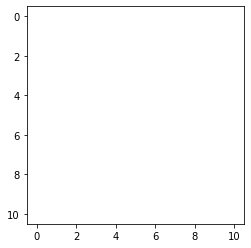

In [ ]:
#Show KSpace
print(KSpace.shape)
img=[]
for i in range(len(phantom)):
  img.append([])
  for j in range(len(phantom)):
    img[i].append([])
    for k in range(len(phantom)):
      img[i][j].append(math.sqrt(KSpace[i][j][k][0]*KSpace[i][j][k][0]+KSpace[i][j][k][1]*KSpace[i][j][k][1]))


img= np.array(img)
#print(img)
#print(img.shape)
import matplotlib.pyplot as plt
#print(np.max(img[5]))
print(np.max(img))
print(np.min(img))
plt.imshow(img[5], cmap='gray', vmin=0, vmax= np.max(img)) #6th (center) slice of KSpace

In [ ]:
#Save KSpace in G-Drive
#filename = "/content/drive/MyDrive/MTP/ksp_sphere"
#np.save(filename, KSpace)

(11, 11, 11, 3)


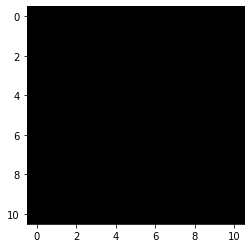

In [ ]:
#KSpace from Z-direction 6th Sheet
ind= 5
print(phantom.shape)
img=np.zeros((len(phantom), len(phantom)))
for i in range(len(phantom)):
  for j in range(len(phantom)):
    for k in range(len(phantom)):
      if(k==ind):
        img[i][j]= math.sqrt(KSpace[i][j][k][0]*KSpace[i][j][k][0]+KSpace[i][j][k][1]*KSpace[i][j][k][1])

plt.imshow(img, cmap='gray')

(11, 11, 11, 3)
(11, 11, 11)


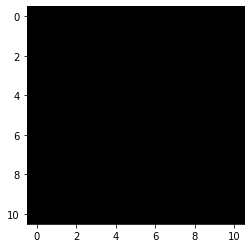

In [ ]:
#Shows phantom
print(phantom.shape)
img=[]
for i in range(len(phantom)):
  img.append([])
  for j in range(len(phantom)):
    img[i].append([])
    for k in range(len(phantom)):
      img[i][j].append(math.sqrt(phantom[i][j][k][0]*phantom[i][j][k][0]))

img= np.array(img)
print(img.shape)
import matplotlib.pyplot as plt
plt.imshow(img[4], cmap='gray')

-----LOADING K-SPACE-----
Min, Max and Avg values of elements in loaded K_space 
0.0   3.245422602970041e-10   1.0824155546310732e-10 

-----CALCULATING INDUCED VOLTAGE AS IN K-SPACE-----
Min, Max and Avg values of elements in Induced Voltage K_space 
1.8478892046508208e-08   1.848813403388737e-08   1.84835126936146e-08 

-----ADDING NOISE TO INDUCED VOLTAGE K-SPACE-----
Min, Max and Avg values of elements in Induced Voltage K_space with Noise 
-7.626857694270837e-09   4.744477277701663e-08   1.8792362668034722e-08 

Noise matrix min, max, std  -2.6111294378664196e-08   2.8964956739706555e-08   9.199130359496753e-09 

-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITHOUT NOISE-----
-----PLOTTING IMAGES W/O NOISE-----


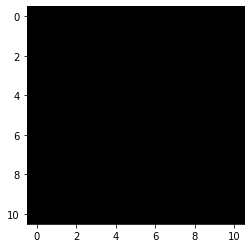

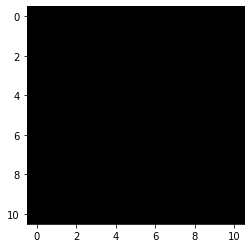

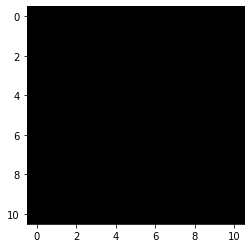

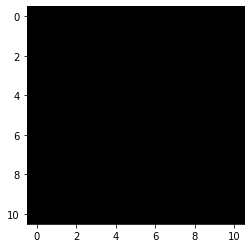

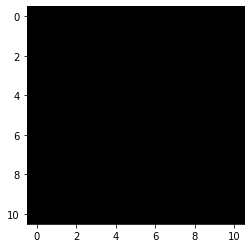

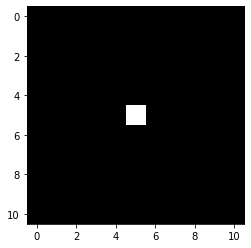

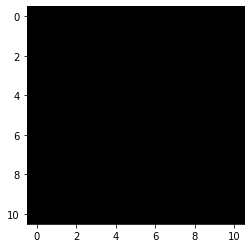

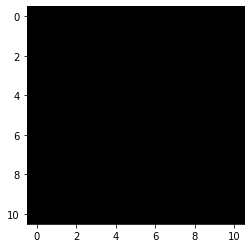

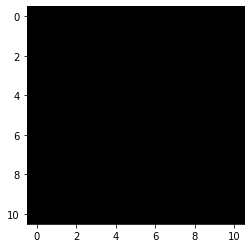

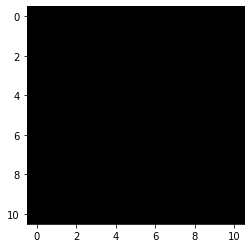

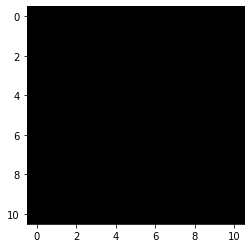






-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITH NOISE-----
-----PLOTTING IMAGES WITH NOISE-----


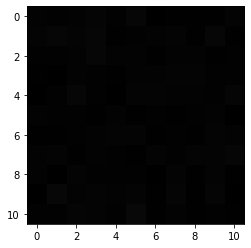

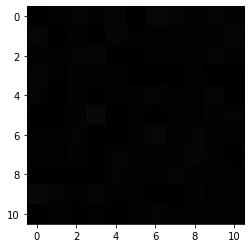

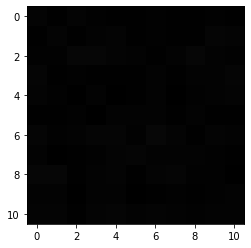

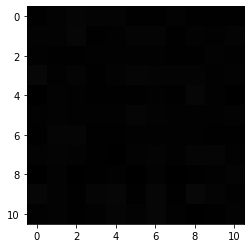

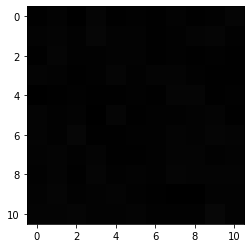

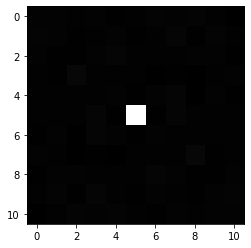

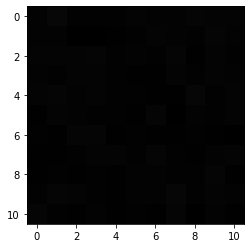

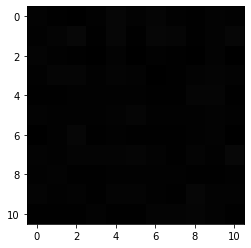

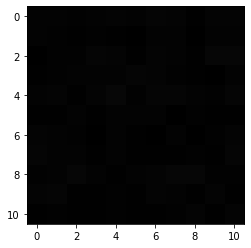

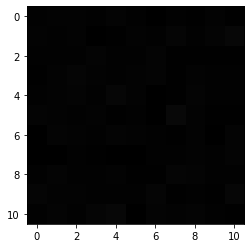

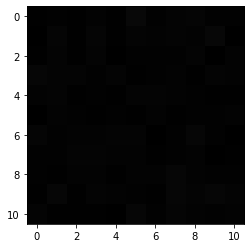

In [ ]:
imgFromKSpace(KSpace)

Experiment with varying B0 and Proton Density and its affect on noise

-----LOADING K-SPACE-----
Min, Max and Avg values of elements in loaded K_space 
0.0   1.6227113014850205e-09   5.407687811096531e-10 

-----CALCULATING INDUCED VOLTAGE AS IN K-SPACE-----
Min, Max and Avg values of elements in Induced Voltage K_space 
9.239446023254104e-08   9.244067016943687e-08   9.241756346807302e-08 

-----ADDING NOISE TO INDUCED VOLTAGE K-SPACE-----
Min, Max and Avg values of elements in Induced Voltage K_space with Noise 
6.194058705541684e-08   1.2053854426276818e-07   9.247683959265937e-08 

Noise matrix min, max, std  -3.04538731771242e-08   2.8111739500563266e-08   8.888654067744868e-09 

-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITHOUT NOISE-----
-----PLOTTING IMAGES W/O NOISE-----


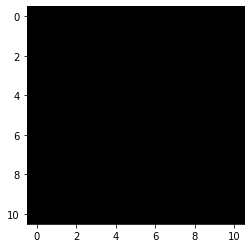

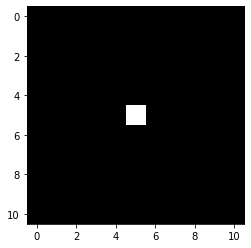








-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITH NOISE-----
-----PLOTTING IMAGES WITH NOISE-----


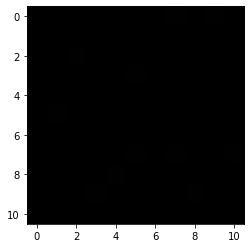

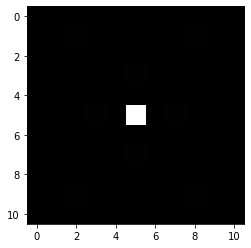

In [ ]:
#temporary cell
#Intialize Phantom
phantom = initialize_phantom(NOP, newparams)
#create_spherical_region(wm_params,[5,5,5],2, phantom)
B0 = 0.0005
phantom[5][5][5]= [5e-7, 4.5, 2.2]
#phantom[6][5][5]= wm_params
#print(phantom[4, 4, 4])

#Generate KSpace
KSpace= np.zeros((NOP, NOP, NOP, 3))
seq(phantom, flip_angle, g1s, g1e, g1max, g2s, g2e, g2max, g3s, g3e, g3, B0, Delta_T, KSpace, delta_x, delta_y, delta_z)
#imgFromKSpace(KSpace)
#"""
#Manually run imgFrom KSpace function
print("-----LOADING K-SPACE-----")
K_space = KSpace
print("Min, Max and Avg values of elements in loaded K_space ")
print(np.min(K_space)," ",np.max(K_space)," ",np.average(K_space),"\n")

print("-----CALCULATING INDUCED VOLTAGE AS IN K-SPACE-----")
K_spaceV = calculateEMFgrid(K_space)
print("Min, Max and Avg values of elements in Induced Voltage K_space ")
print(np.min(K_spaceV)," ",np.max(K_spaceV)," ",np.average(K_spaceV),"\n")
  
print("-----ADDING NOISE TO INDUCED VOLTAGE K-SPACE-----")
K_spaceN = White_noise_matrix_adder(K_spaceV)
print("Min, Max and Avg values of elements in Induced Voltage K_space with Noise ")
print(np.min(K_spaceN)," ",np.max(K_spaceN)," ",np.average(K_spaceN),"\n")

print("Noise matrix min, max, std ", np.min(K_spaceN-K_spaceV)," ",np.max(K_spaceN-K_spaceV)," ",np.std(K_spaceN-K_spaceV),"\n")

print("-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITHOUT NOISE-----")
ifft = InverseFourierTransform(K_spaceV)
print("-----PLOTTING IMAGES W/O NOISE-----")
for i in [0,5]:
  im = np.abs(ifft[i])
  plt.imshow(im, cmap='gray',vmin=0, vmax=np.max(np.abs(ifft)))
  plt.show()
  print("\n")
print("\n\n\n\n")

print("-----APPLYING INVERSE FOURIER TRANSFORM ON RESULTANT K-SPACE WITH NOISE-----")
ifftN = InverseFourierTransform(K_spaceN)
print("-----PLOTTING IMAGES WITH NOISE-----")
for i in [0,5]:
  imN = np.abs(ifftN[i])
  plt.imshow(imN, cmap='gray',vmin=0, vmax=np.max(np.abs(ifftN)))
  plt.show()
  print("\n")
print("\n\n\n\n")
#"""